In [1]:
# conda create -n python_a3_temp_env python==3.10
# conda activate python_a3_temp_env
# https://github.com/stac-utils/pystac-client
# conda install pystac-client
# conda install rasterio, matplotlib stackstac geopandas hvplot geoviews

In [2]:
from pystac_client import Client
from pystac import ItemCollection
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from copy import deepcopy

import geopandas as gpd
import pandas as pd
from shapely.geometry import shape

import odc.stac
from pystac_client import Client
import numpy as np
import rioxarray 


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
client = Client.open("https://earth-search.aws.element84.com/v1")

collection_search = client.collection_search()
    
print(f"{collection_search.matched()} collections found")

for collection in collection_search.collections():
    print(collection.id)

9 collections found
sentinel-2-pre-c1-l2a
cop-dem-glo-30
naip
cop-dem-glo-90
landsat-c2-l2
sentinel-2-l2a
sentinel-2-l1c
sentinel-2-c1-l2a
sentinel-1-grd


In [4]:
import math
import pandas as pd 

def s3_to_https(s3_url):
    if not s3_url.startswith("s3://"):
        raise ValueError("Not a valid S3 path.")
    s3_path = s3_url.replace("s3://", "")
    bucket, *key_parts = s3_path.split("/")
    key = "/".join(key_parts)
    return f"https://{bucket}.s3.amazonaws.com/{key}"

def plot_thumbnails(df_assets):
    thumbnails = []
    titles = []

    # Collect thumbnails and titles
    for _, item in df_assets.iterrows():
        # print(item)
        # for key, asset in item.assets.items():
            # if key == "thumbnail":
        s3_url = item["thumbnail"]
        https_url = s3_to_https(s3_url)
        try:
            response = requests.get(https_url)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert("RGB")
            thumbnails.append(img)
            titles.append(item["id"])
        except Exception as e:
            print(f"Failed to load thumbnail for {item.id}: {e}")

    # Determine grid layout
    n_images = len(thumbnails)
    n_cols = 4  # You can change this to 3, 5, etc.
    n_rows = math.ceil(n_images / n_cols)

    # Plot thumbnails in grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        if idx < n_images:
            ax.imshow(thumbnails[idx])
            ax.set_title(titles[idx], fontsize=9)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()
    plt.show()

# convert a list of STAC Items into a GeoDataFrame
def items_to_geodataframe(items):
    _items = []
    for i in items:
        print(i.keys(),"hbjhavbhvhvhvhv")
        _i = {
            "id": i["id"],
            "type": i["type"],
            "stac_version": i["stac_version"],
            "links": i["links"],
            "stac_extensions": i["stac_extensions"],
            "bbox": i["bbox"],
            "geometry": shape(i["geometry"]),
            # "datetime": str(i["datetime"])
        }
        _items.append(_i)
    return gpd.GeoDataFrame(_items, geometry="geometry")



import hvplot.pandas  # noqa: F401


# plot polygons on a map with background tiles.
def plot_bbox(data, *args, **kwargs):
    return data.hvplot.polygons(
        *args,
        geo=True,
        projection="GOOGLE_MERCATOR",
        xaxis=None,
        yaxis=None,
        frame_width=600,
        frame_height=600,
        fill_alpha=0,
        line_width=4,
        **kwargs,
    )


# plot polygons on a map with background tiles.
def plot_aoi(data, *args, **kwargs):
        geom_type=data.geometry.type[0]
        if geom_type=="Point":
            return data.hvplot.points(
                *args,
                geo=True,
                projection="GOOGLE_MERCATOR",
                xaxis=None,
                yaxis=None,
                frame_width=600,
                frame_height=600,
                fill_alpha=0,
                line_width=4,
                **kwargs,
            )
        elif geom_type=="Polygon":
            return data.hvplot.points(
                *args,
                geo=True,
                projection="GOOGLE_MERCATOR",
                xaxis=None,
                yaxis=None,
                frame_width=600,
                frame_height=600,
                fill_alpha=0,
                line_width=4,
                **kwargs,
            )
        else:
            raise ValueError(f"Unsupported geometry type: {geom_type}")



In [5]:
def search_sar_data(aoi, datetime):
    client = Client.open("https://earth-search.aws.element84.com/v1")
    search = client.search(
        # max_items=50,
        collections= "sentinel-1-grd"   ,
        intersects=aoi,
        datetime=datetime,
        )

    items = list(search.items_as_dicts())

    # convert geometry to a GeoDataFrame
    gdf_aoi = gpd.GeoDataFrame([{"geometry": shape(aoi)}])

    # convert found items to a GeoDataFrame
    gdf_metadata = items_to_geodataframe(items)
    # print(items_gdf.head())

    # Convert search results into an ItemCollection
    item_collection = ItemCollection(search.get_items())

    # print(items,"items")
    # print(item_collection,"items collection")

    # item_metadata = []
    item_properties=[]
    item_assets=[]

    for item in item_collection:
        # Collect properties with ID
        item_properties.append({
            "id": item.id,
            **item.properties
        })

        # Collect assets with ID
        item_assets.append({
            "id": item.id,
            **{k: v.href for k, v in item.assets.items()}
        })

    # Convert each list to a DataFrame
    # df_metadata = pd.DataFrame(item_metadata)
    df_properties = pd.DataFrame(item_properties)
    df_assets = pd.DataFrame(item_assets)

    return search, gdf_metadata, gdf_aoi, df_properties, df_assets



dict_keys(['type', 'stac_version', 'id', 'properties', 'geometry', 'links', 'assets', 'bbox', 'stac_extensions', 'collection']) hbjhavbhvhvhvhv
dict_keys(['type', 'stac_version', 'id', 'properties', 'geometry', 'links', 'assets', 'bbox', 'stac_extensions', 'collection']) hbjhavbhvhvhvhv


/Users/rabinatwayana/Rabina/anaconda3/envs/python_a3_temp_env/lib/python3.10/site-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


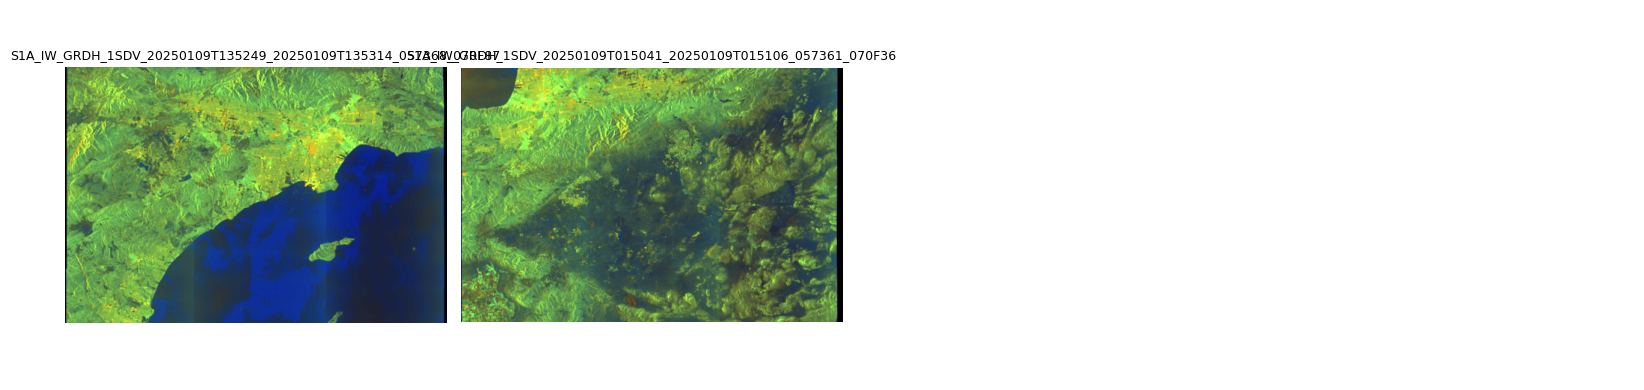

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]
   .Points.I   :Points   [Longitude,Latitude]

In [6]:
import logging

logging.getLogger("pystac_client").setLevel(logging.WARNING)

aoi_polygon = {"type":"Polygon",
               "coordinates":[[
                   [-118.185081,34.137719],
                   [-118.185081,34.266631],
                   [-117.983208,34.266631],
                   [-117.983208,34.137719],
                   [-118.185081,34.137719]]]}


aoi_point = {
    "type": "Point",
    "coordinates": [-118.070927,34.205155]
}

# query,gdf_metadata,gdf_aoi, df_properties, df_assets= search_sar_data(aoi=aoi_point, datetime = "2024-12-20/2025-01-25")
query,gdf_metadata,gdf_aoi, df_properties, df_assets= search_sar_data(aoi=aoi_point, datetime = "2025-01-01/2025-01-10")

plot_thumbnails(df_assets)
plot_aoi(gdf_aoi, tiles="OSM", line_color="red")
plot_bbox(gdf_metadata, tiles="OSM")
# plot_polygons(gdf_items, tiles="OSM") * plot_polygons(gdf_aoi, line_color="red")
plot_bbox(gdf_metadata, tiles="OSM") * plot_aoi(gdf_aoi, line_color="red")

In [7]:
gdf_metadata

,id,type,stac_version,links,stac_extensions,bbox,geometry
0,S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87,Feature,1.0.0,"[{'rel': 'self', 'type': 'application/geo+json', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd/items/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87'}, {'rel': 'canonical', 'href': 's3://earthsearch-data/sentinel-1-grd/2025/1/9/IW/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87.json', 'type': 'application/json'}, {'rel': 'parent', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd'}, {'rel': 'collection', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd'}, {'rel': 'root', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1'}, {'rel': 'thumbnail', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd/items/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87/thumbnail'}]","[https://stac-extensions.github.io/projection/v1.1.0/schema.json, https://stac-extensions.github.io/raster/v1.1.0/schema.json, https://stac-extensions.github.io/sar/v1.0.0/schema.json, https://stac-extensions.github.io/storage/v1.0.0/schema.json, https://stac-extensions.github.io/sat/v1.0.0/schema.json, https://stac-extensions.github.io/processing/v1.1.0/schema.json]","[-119.3335521, 32.6737633, -116.3709724, 34.5764799]","POLYGON ((-119.04225 34.57648, -119.33355 33.07168, -118.02058 32.88154, -116.69502 32.67376, -116.37097 34.18318, -117.72928 34.39095, -119.04225 34.57648))"
1,S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36,Feature,1.0.0,"[{'rel': 'self', 'type': 'application/geo+json', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd/items/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36'}, {'rel': 'canonical', 'href': 's3://earthsearch-data/sentinel-1-grd/2025/1/9/IW/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36.json', 'type': 'application/json'}, {'rel': 'parent', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd'}, {'rel': 'collection', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd'}, {'rel': 'root', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1'}, {'rel': 'thumbnail', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd/items/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36/thumbnail'}]","[https://stac-extensions.github.io/storage/v1.0.0/schema.json, https://stac-extensions.github.io/raster/v1.1.0/schema.json, https://stac-extensions.github.io/processing/v1.1.0/schema.json, https://stac-extensions.github.io/sar/v1.0.0/schema.json, https://stac-extensions.github.io/projection/v1.1.0/schema.json, https://stac-extensions.github.io/sat/v1.0.0/schema.json]","[-119.1324767, 33.76746, -116.1038947, 35.6694387]","POLYGON ((-116.41259 35.66944, -117.75673 35.48268, -119.13248 35.27527, -118.92101 34.36297, -118.79786 33.76746, -117.47883 33.97123, -116.10389 34.1669, -116.41259 35.66944))"


In [8]:
df_properties.columns


Index(['id', 'sar:frequency_band', 'sar:center_frequency',
       'sar:observation_direction', 'sar:instrument_mode', 'sar:polarizations',
       'sar:product_type', 'sar:resolution_range', 'sar:resolution_azimuth',
       'sar:pixel_spacing_range', 'sar:pixel_spacing_azimuth',
       'sar:looks_range', 'sar:looks_azimuth', 'sar:looks_equivalent_number',
       'sat:platform_international_designator', 'sat:orbit_state',
       'sat:absolute_orbit', 'sat:relative_orbit', 'proj:bbox', 'proj:shape',
       'proj:transform', 'proj:centroid', 'platform', 'constellation',
       'start_datetime', 'end_datetime', 's1:instrument_configuration_ID',
       's1:datatake_id', 's1:product_timeliness', 's1:processing_level',
       's1:resolution', 's1:orbit_source', 's1:slice_number',
       's1:total_slices', 's1:shape', 's1:product_identifier',
       's1:processing_datetime', 'storage:platform', 'storage:region',
       'storage:requester_pays', 'datetime', 'processing:software', 'created',
    

In [9]:
df_properties

,id,sar:frequency_band,sar:center_frequency,sar:observation_direction,sar:instrument_mode,sar:polarizations,sar:product_type,sar:resolution_range,sar:resolution_azimuth,sar:pixel_spacing_range,sar:pixel_spacing_azimuth,sar:looks_range,sar:looks_azimuth,sar:looks_equivalent_number,sat:platform_international_designator,sat:orbit_state,sat:absolute_orbit,sat:relative_orbit,proj:bbox,proj:shape,proj:transform,proj:centroid,platform,constellation,start_datetime,end_datetime,s1:instrument_configuration_ID,s1:datatake_id,s1:product_timeliness,s1:processing_level,s1:resolution,s1:orbit_source,s1:slice_number,s1:total_slices,s1:shape,s1:product_identifier,s1:processing_datetime,storage:platform,storage:region,storage:requester_pays,datetime,processing:software,created,updated,proj:code
0,S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87,C,5.405,right,IW,"[VV, VH]",GRD,20,22,10,10,5,1,4.4,2014-016A,descending,57368,71,"[-119.366325, 32.671017, -116.354919, 34.583099]","[25566, 16716]","[0.00018015111270638958, 0, -119.366325, 0, -7.479003363842596e-05, 34.583099]","{'lat': 33.62965, 'lon': -117.87058}",sentinel-1a,sentinel-1,2025-01-09T13:52:49.295428Z,2025-01-09T13:53:14.293838Z,7,462727,Fast-24h,1,high,RESORB,8,13,"[25566, 16716]",S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3,2025-01-09T15:47:44.000000Z,AWS,eu-central-1,True,2025-01-09T13:53:01.794633Z,{'sentinel1-to-stac': '2023.05.17'},2025-01-09T16:32:28.056Z,2025-01-09T16:32:28.056Z,EPSG:4326
1,S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36,C,5.405,right,IW,"[VV, VH]",GRD,20,22,10,10,5,1,4.4,2014-016A,ascending,57361,64,"[-119.133232, 33.767582, -116.060799, 35.677593]","[25670, 16703]","[0.00018394497994372291, 0, -119.133232, 0, -7.440634982469825e-05, 35.677593]","{'lat': 34.72518, 'lon': -117.58633}",sentinel-1a,sentinel-1,2025-01-09T01:50:41.193183Z,2025-01-09T01:51:06.192259Z,7,462646,Fast-24h,1,high,RESORB,2,12,"[25670, 16703]",S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1,2025-01-09T06:30:23.000000Z,AWS,eu-central-1,True,2025-01-09T01:50:53.692721Z,{'sentinel1-to-stac': '2023.05.17'},2025-01-09T06:46:57.984Z,2025-01-09T06:46:57.984Z,EPSG:4326


In [10]:
df_properties[['id',"sar:polarizations", "sar:resolution_range","sat:orbit_state","proj:code"]]

,id,sar:polarizations,sar:resolution_range,sat:orbit_state,proj:code
0,S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87,"[VV, VH]",20,descending,EPSG:4326
1,S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36,"[VV, VH]",20,ascending,EPSG:4326


In [11]:
df_assets.columns


Index(['id', 'safe-manifest', 'schema-product-vh', 'schema-product-vv',
       'schema-calibration-vh', 'schema-calibration-vv', 'schema-noise-vh',
       'schema-noise-vv', 'thumbnail', 'vh', 'vv'],
      dtype='object')

In [12]:
df_assets

,id,safe-manifest,schema-product-vh,schema-product-vv,schema-calibration-vh,schema-calibration-vv,schema-noise-vh,schema-noise-vv,thumbnail,vh,vv
0,S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/manifest.safe,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/annotation/rfi/rfi-iw-vh.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/annotation/rfi/rfi-iw-vv.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/annotation/calibration/calibration-iw-vh.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/annotation/calibration/calibration-iw-vv.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/annotation/calibration/noise-iw-vh.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/annotation/calibration/noise-iw-vv.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/preview/quick-look.png,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/measurement/iw-vh.tiff,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/measurement/iw-vv.tiff
1,S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/manifest.safe,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/annotation/rfi/rfi-iw-vh.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/annotation/rfi/rfi-iw-vv.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/annotation/calibration/calibration-iw-vh.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/annotation/calibration/calibration-iw-vv.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/annotation/calibration/noise-iw-vh.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/annotation/calibration/noise-iw-vv.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/preview/quick-look.png,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/measurement/iw-vh.tiff,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/measurement/iw-vv.tiff


/Users/rabinatwayana/Rabina/anaconda3/envs/python_a3_temp_env/lib/python3.10/site-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


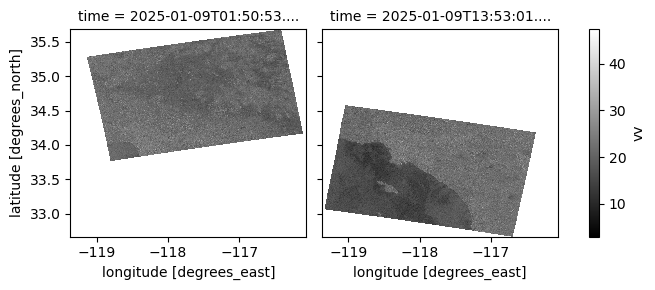

In [13]:


# Load the data using odc.stac
xx = odc.stac.load(
    query.get_items(),
    # bands=["vv", "vh"],
    bands=["vv"],

    # resolution=10,
    # groupby="solar_day",  # or 'time' for S1
    # chunks={"time": 1},   # for dask
)

xx_dB = xx.copy()
xx_dB['vv'] = 10 * np.log10(xx.vv.where(xx.vv > 0))  # Avoid log of zero or negative
# xx_dB['vh'] = 10 * np.log10(xx.vh.where(xx.vh > 0))

# Visualize VV band
# xx.vv.plot.imshow(col="time")
xx_dB.vv.plot.imshow(col="time", cmap="gray")
# xx_dB.vh.plot.imshow(col="time", cmap="gray")



In [ ]:
# print(hasattr(xx_dB['vv'], 'rio'))

# vv = xx_dB.vv.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")

True


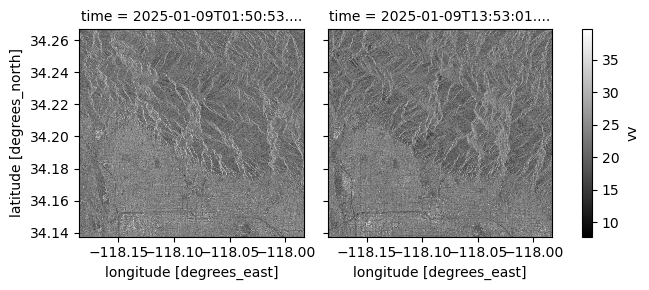

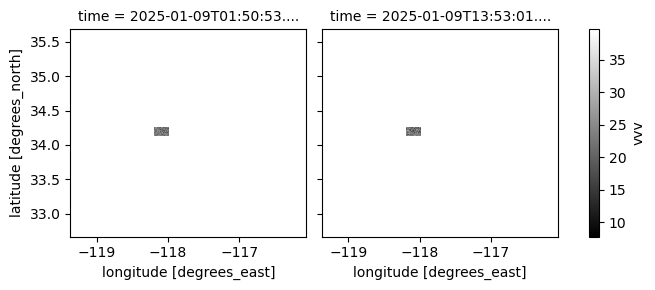

In [ ]:
vv = xx_dB['vv']
# Step 5: Clip by AOI
gdf_aoii = gpd.GeoDataFrame([{"geometry": shape(aoi_polygon)}])
vv_clipped = vv.rio.clip(gdf_aoii.geometry)

# Optional: Plot clipped result
# vv_clipped.plot.imshow(col="time", cmap="gray")
vv_clipped.plot.imshow(col="time", cmap="gray")

# xx_dB['vvv'] =  xx_dB['vv'].rio.clip(gdf_aoii.geometry)
# xx_dB.vvv.plot.imshow(col="time", cmap="gray")